## Recursion formulae for $\mathcal{I}_v$

In this notebook we validate our recursion formulae for the integral $\mathcal{I}$.

In [1]:
%matplotlib inline

In [2]:
%run notebook_setup.py

In [3]:
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy.special import binom

Here's the definition of the $\mathcal{I}$ integral, computed numerically:

In [6]:
def Iexact(v, kappa):
    """
    The function I_v evaluated by direct numerical integration.
    
    """
    res = 0
    for i in range(0, len(kappa), 2):
        func = lambda x: np.sin(x) ** (2 * v)
        res += quad(func, 0.5 * kappa[i], 0.5 * kappa[i + 1], epsabs=1e-12, epsrel=1e-12,)[0]
    return res

And here's our expression, computed recursively from a trivial lower boundary condition:

In [ ]:
def Delta(x):
    """The sum over the pairwise differences of an array."""
    return sum(-np.array(x)[::2] + np.array(x)[1::2])


def I(v, kappa):
    """
    The function I_v computed from a lower boundary condition
    and a two-term upward recurrence relation.
    
    """
    if v == 0:
        return 0.5 * Delta(kappa)
    else:
        term = np.sin(0.5 * kappa) ** (2 * v - 1) * np.cos(0.5 * kappa)
        return 1.0 / (2 * v) * ((2 * v - 1) * I(v - 1, kappa) - Delta(term))

We can validate the expression over a range of $\{\kappa_1, \kappa_2 \}$ for $v=3$:

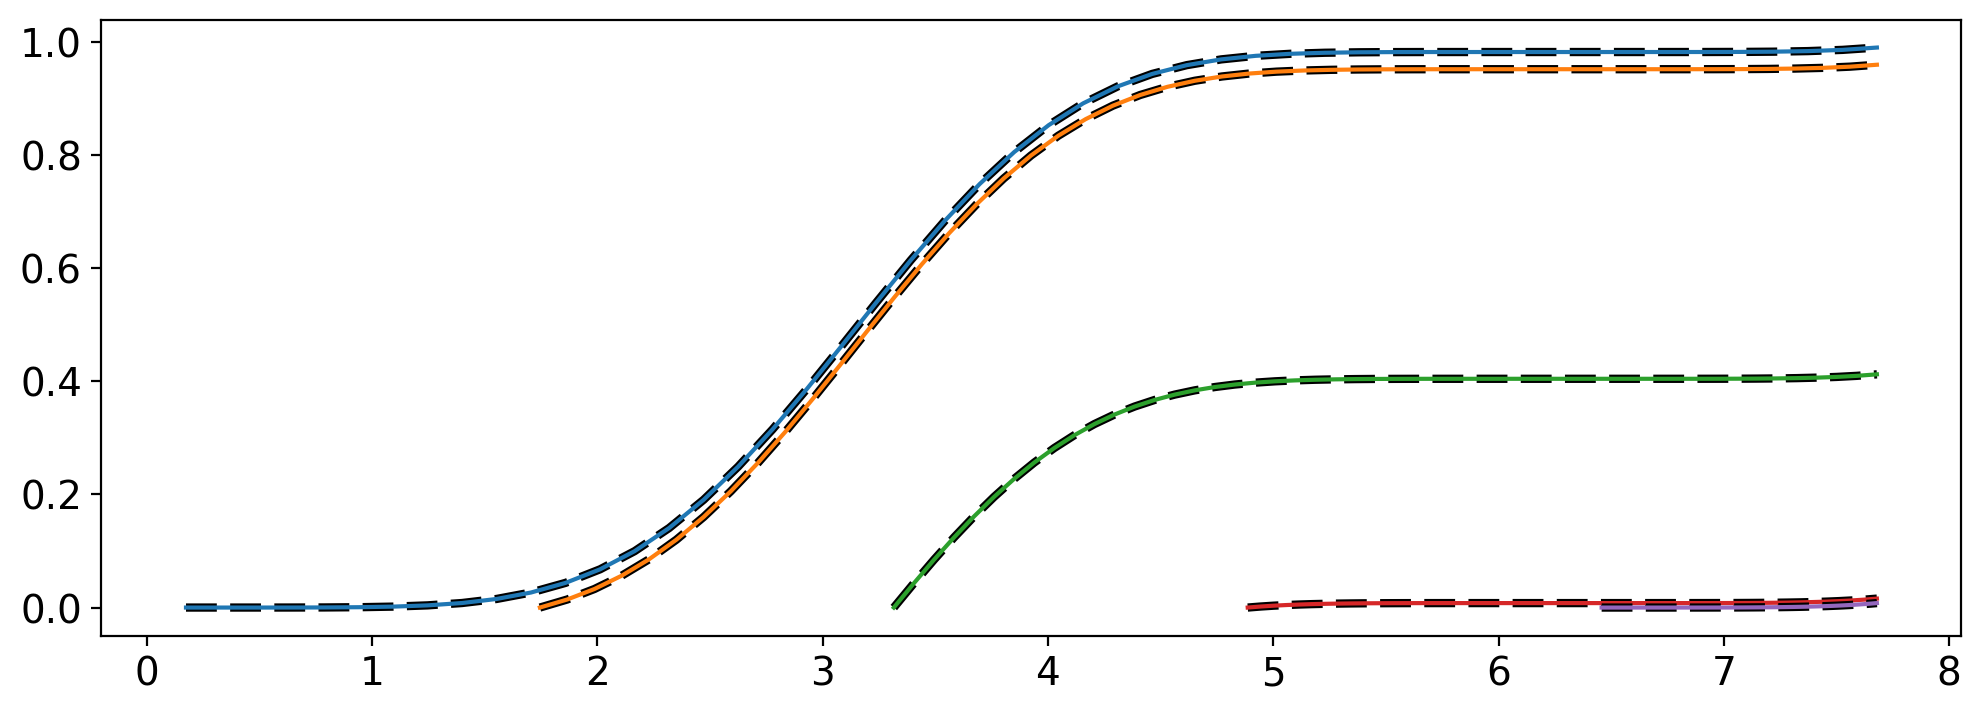

In [21]:
# Validation
for kappa1 in np.array([10, 100, 190, 280, 370]) * np.pi / 180:
    arr = np.linspace(kappa1, 440 * np.pi / 180, 50)
    plt.plot(arr, [Iexact(3, np.array([kappa1, kappa2])) for kappa2 in arr], "k--", lw=3)
    plt.plot(arr, [I(3, np.array([kappa1, kappa2])) for kappa2 in arr])

## Solver for I

Here's the full recursive solver for all $\mathcal{I}_v$ in one go:

In [17]:
def solve(N, kappa):
    
    # Useful quantities
    s = np.sin(0.5 * kappa)
    s2 = s ** 2
    term = s * np.cos(0.5 * kappa)
    
    # Lower boundary
    I = np.empty(N + 1)
    I[0] = 0.5 * Delta(kappa)
    
    # Recurse upward
    for v in range(1, N + 1):
        I[v] = 1.0 / (2 * v) * ((2 * v - 1) * I[v - 1] - Delta(term))
        term *= s2
        
    return I

And here's a simply check that the recurssive solver agrees with direct numerical integration for a specific combination of input parameters:

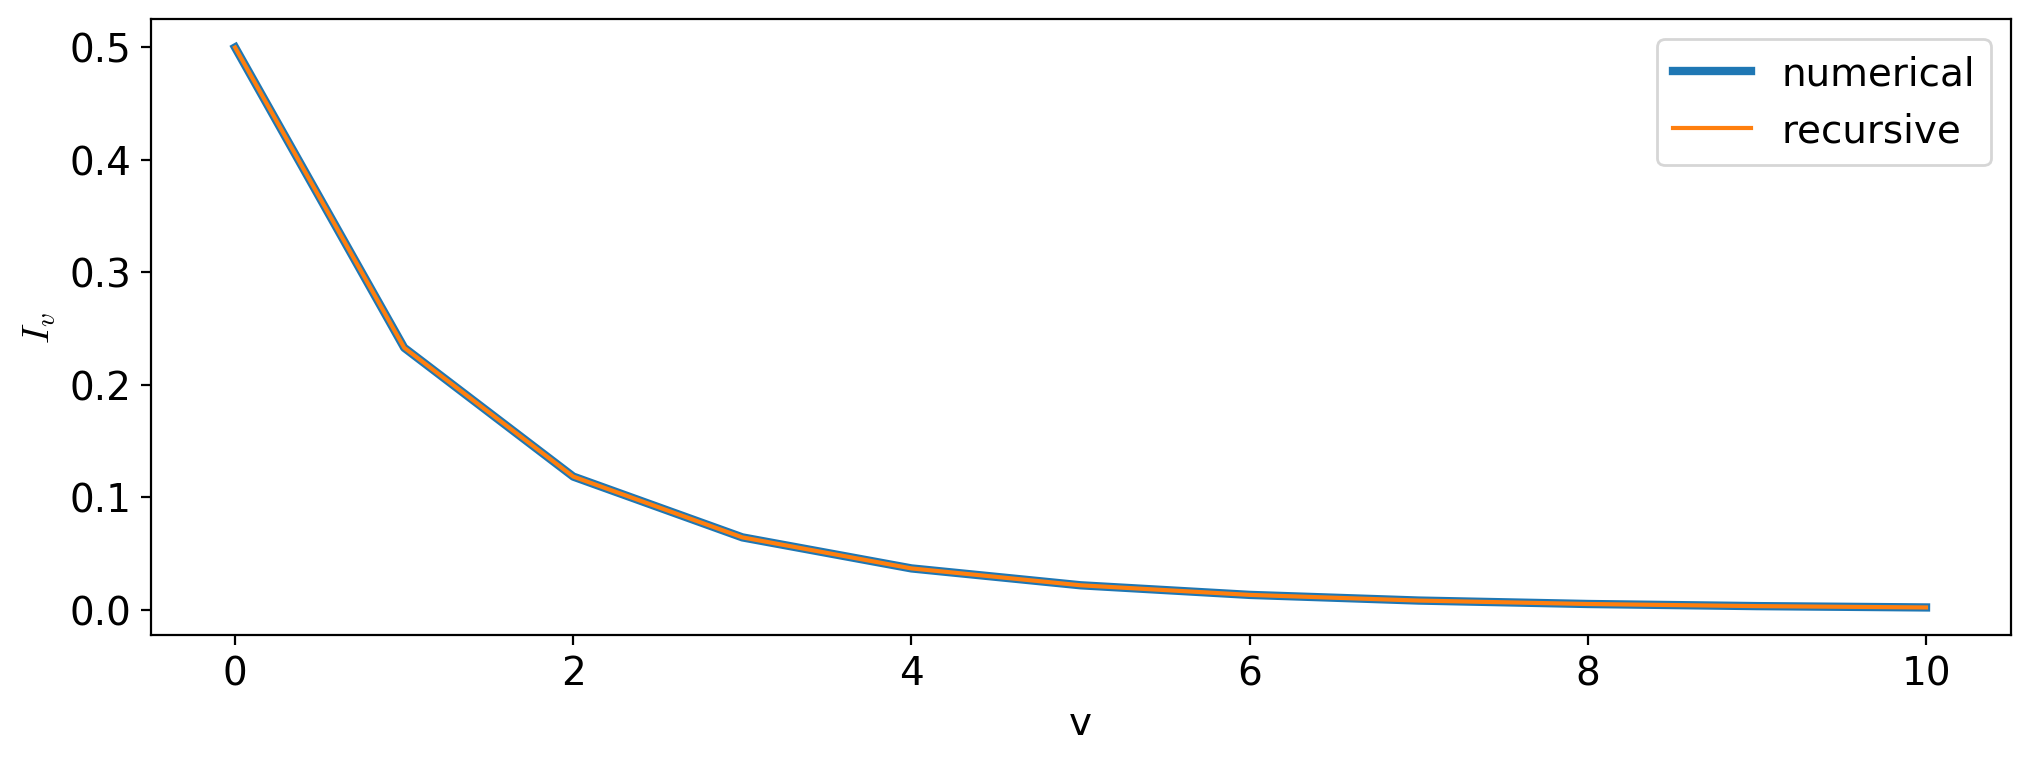

In [18]:
kappa = np.array([1.0, 2.0])
N = 10
plt.plot(solve_numerical(N, kappa), lw=3, label="numerical")
plt.plot(solve(N, kappa), lw=1.5, label="recursive")
plt.xlabel("v")
plt.ylabel("$I_v$")
plt.legend();

## Solver stability

We pick random values of $\{\kappa_1, \kappa_2 \}$ and compute the difference between the numerical and recursive solver to test the numerical stability of the algorithm:

In [19]:
def solve_numerical(N, kappa):
    return np.array([Iexact(v, kappa) for v in range(N + 1)])

def random_kappa():
    """Random (kappa1, kappa2) in the range [0, 2pi] with kappa2 > kappa1."""
    kappa1 = 2 * np.pi * np.random.random()
    kappa2 = kappa1 + (2 * np.pi - kappa1) * np.random.random()
    return np.array([kappa1, kappa2])

ntimes = 1000
N = 20
logdiff = np.zeros((ntimes, N + 1))
for i in tqdm(range(ntimes)):
    kappa = random_kappa()
    logdiff[i] = np.log10(np.maximum(1e-16, np.abs(solve(N, kappa) - solve_numerical(N, kappa))))

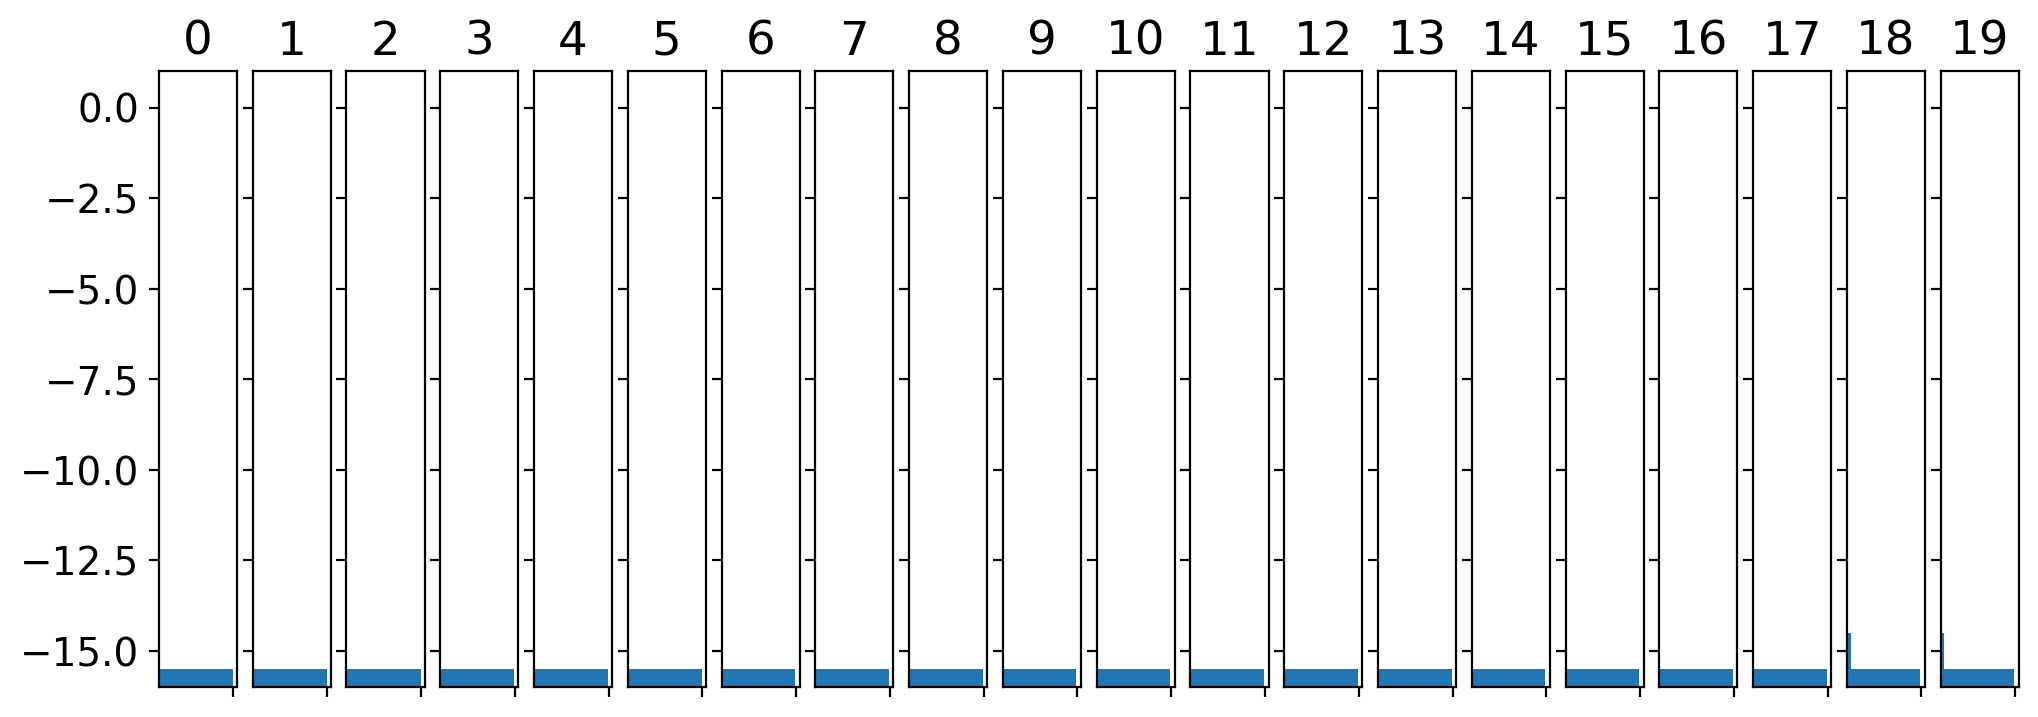

In [20]:
fig, ax = plt.subplots(1, N, sharex=True, sharey=True)
ax[0].set_ylim(-16, 1)
ax[0].set_xscale("log")
ax[0].set_xticklabels([])
for i, axis in enumerate(ax):
    axis.set_title(i)
    axis.hist(logdiff[:, i], orientation="horizontal", bins=np.arange(-16.5, 0))

The expressions agree to within better than $10^{-15}$ in all cases.